In [1]:
from __future__ import division

import numpy as np

from math import sqrt, log

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import seaborn as sns
import colorcet as cc
sns.set(style="white", palette="deep", color_codes=True)
sns.set_context("notebook", font_scale=1.2)
plt.rcParams["axes.labelsize"] = 16

def force_aspect(ax, aspect=1):
    """force a matplotlib axis to have the specified aspect ratio on the screen"""
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    a = (np.max(xlim) - np.min(xlim)) / (np.max(ylim) - np.min(ylim))
    ax.set_aspect(a / aspect)
    
golden_ratio = 1.61803398875

In [2]:
stopwords = ["a", "about", "above", "according", "across", "affect", "after", \
"again", "against", "all", "almost", "alone", "along", "already", \
"also", "although", "always", "among", "an", "and", "another", "any", \
"anyone", "anything", "anywhere", "apt", "are", "argue", "around", \
"as", "asserted", "at", "back", "be", "became", "because", "become", \
"becomes", "been", "before", "behind", "being", "better", "between", \
"both", "but", "by", "can", "cannot", "common", "commonly", \
"comparable", "consequently", "considerable", "could", "course", \
"degree", "did", "do", "done", "down", "dramatically", "during", \
"each", "either", "enough", "even", "ever", "every", "everyone", \
"everything", "everywhere", "extent", "few", "find", "first", \
"follow", "for", "four", "from", "full", "further", "get", "give", \
"go", "had", "has", "have", "he", "hence", "her", "here", "herself", \
"him", "himself", "his", "how", "however", "if", "imply", \
"importance", "in", "interest", "into", "is", "it", "its", "itself", \
"join", "keep", "kind", "largely", "last", "least", "less", "made", \
"many", "may", "me", "might", "more", "moreover", "most", "mostly", \
"much", "must", "my", "myself", "necessary", "never", "next", "no", \
"nobody", "noone", "nor", "not", "nothing", "now", "nowhere", "of", \
"off", "often", "on", "once", "one", "only", "or", "other", "others", \
"our", "out", "over", "part", "particularly", "per", "perhaps", \
"possible", "principle", "put", "rather", "requisite", "same", \
"second", "see", "seem", "seemed", "seeming", "seems", "several", \
"shall", "she", "should", "show", "side", "since", "so", "some", \
"someone", "something", "somewhere", "still", "substance", "such", \
"suggest", "take", "than", "that", "the", "their", "them", "then", \
"there", "therefore", "these", "they", "thing", "this", "those", \
"though", "three", "through", "throughout", "thus", "to", "together", \
"too", "toward", "two", "typical", "typically", "under", \
"unexpected", "until", "up", "upon", "us", "use", "using", "very", \
"was", "we", "well", "were", "what", "when", "where", "whether", \
"which", "while", "whilst", "who", "whole", "whose", "why", "will", \
"with", "within", "without", "would", "yet", "you", "your", "yours"]

# Exploratory Analysis: Finding the words which best distinguish Madison from Hamilton

We'll first try this the standard way, which is easy and informative, but unfortunately also inadequate for the present task.  The basic idea is to determine which words most distinguish Hamilton from Madison, build some linear function which discriminates them, and then apply this model to the disputed papers to determine their authorship.

This approach is easy to do, but it suffers from two problems: since Hamilton and Madison are *so* similar in their writing style, most of what we fit is likely to be noise.  And more importantly, there's no way for a linear discriminant to attach an uncertainty to its determination... recall that my entire purpose here is to find an honest and quantitative assessment of the probability that each man wrote the disputed papers.

## Tally up word counts

We want to tally up the occurrences of each of these stop words in our training sets.  We'll split the sets into chunks of 1000 words, so that we can also measure the variance:

(My choice of 1000 words here is arbitrary, but I think it's reasonable for writing.  If word rates are Poisonian, then the mean rate and variance should both scale linearly with this fragment size.  Later, we'll see evidence that word rates are "over-dispersed," with a larger variance than Poisson can accomodate.  Fortunately, this non-Poisson-ness seems to be intrisic to each word, and not to depend strongly on fragment length.  In either case, this arbitrary choice does not much influence my results.)

In [3]:
import nltk
from collections import Counter

In [4]:
def sample_usage(filename):
    """Split filename into chunks of 1000 words, then tally the instances of
    each of the stopwords in each chunk.  Return the mean and variance for
    each word."""
    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())

    # split into chunks of 1000 words
    n=1000
    samples = [ all_words[i:i + n] 
                for i in xrange(0, len(all_words), n) ]

    # tally each of the stopwords, for each chunk
    c = [ Counter(s) for s in samples ]
    x = [ [ cc[w] for w in stopwords ] for cc in c ]
    x = np.asarray(x)

    # return lists of the mean and variance for each stop word
    mu = np.mean(x, axis=0)
    va = np.var(x,  axis=0)
    
    return (mu, va)

In [5]:
mu_m, v_m = sample_usage('../authors/madison-corpus-small.txt')
mu_h, v_h = sample_usage('../authors/hamilton-corpus-small.txt')

Find words for which the difference in Madison's and Hamilton's usage exceeds the variance:

In [6]:
# recall that i floor the occurrence rates at one per million...
# for Poissonian statistics, this also floors the variance at one per million
delta = (mu_m - mu_h) / np.sqrt(v_m + v_h + 1.0e-6)
delta = np.abs(delta)
ind = np.flipud(np.argsort(delta))

We can get a sense of the available information by making a quick plot:

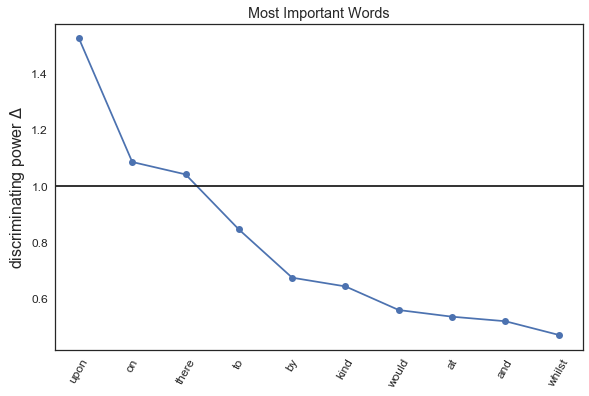

In [7]:
fig, ax = plt.subplots(figsize=(12,6))

num = 10
ax.plot(delta[ind][:num], '-o')
ax.set_ylabel('discriminating power $\Delta$')

# label x-ticks with words and force it to show every one of them
ax.set_xticks(range(num))
labels = [ stopwords[i] for i in ind[:num] ]
ax.set_xticklabels(labels, rotation=60);
ax.axhline(1.0, color='k')

ax.set_title('Most Important Words');
force_aspect(ax, aspect=golden_ratio)

Clearly, the first 3 points stand out from the rest, with $\Delta > 1$ (if barely).  The rest of the detections are not technically significant.  So we'll have a look at these first three:

In [8]:
keep = np.where(delta>1)[0]
set1 = [ stopwords[i] for i in keep ]
print set1

['on', 'there', 'upon']


And let's also keep everything with delta>0.5, just in case it helps us:

In [9]:
keep = np.where(delta>0.5)[0]
set2 = [ stopwords[i] for i in keep ]
print set2

['and', 'at', 'by', 'kind', 'on', 'there', 'to', 'upon', 'would']


## Investigate key words by eye

We can start by plotting our training set according to the occurrences of each of our key words.  If Madison's and Hamilton's clearly seperate, then this might suggest a way to tell them apart.  Once can always hope!

In [12]:
import glob

In [22]:
def measure(filename, wordlist=stopwords):
    """count frequency for each word in wordlist for the file filename"""
    with open(filename, 'r') as f:
        raw = f.read()

    all_words = nltk.word_tokenize(raw.lower())
    c = Counter(all_words)
    
    tally = [ c[word] for word in wordlist ]    
    
    return np.asarray(tally) / len(all_words)

xm = [ measure(f, stopwords) for f in glob.glob('../authors/madison/*.txt')]
xh = [ measure(f, stopwords) for f in glob.glob('../authors/hamilton/*.txt')]

# transpose data so that each row corresponds to a word
# (and each column corresponds to a different federalist paper)
xm = np.asarray(xm).T
xh = np.asarray(xh).T

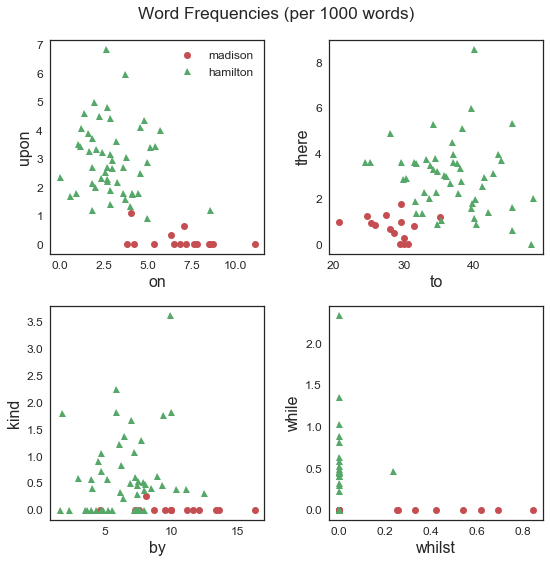

In [28]:
fig=plt.figure(figsize=(8, 8))
gs=GridSpec(2,2) # one row, two columns

ax1=fig.add_subplot(gs[0,0]) # first row, first column
ax2=fig.add_subplot(gs[0,1]) # first row, second column
ax3=fig.add_subplot(gs[1,0]) # second row, first column
ax4=fig.add_subplot(gs[1,1]) # second row, second column

def compare_usage(x, word1, word2):
    return (x[stopwords.index(word1)] * 1000, 
            x[stopwords.index(word2)] * 1000)

def plot_comparison(w1, w2, ax):
    x, y = compare_usage(xm, w1, w2)
    ax.plot(x, y, 'o', color='r', label = 'madison')
    x, y = compare_usage(xh, w1, w2)
    ax.plot(x, y, '^', color='g', label = 'hamilton')
    ax.set_xlabel(w1)
    ax.set_ylabel(w2)

plot_comparison('on',     'upon',  ax1)
plot_comparison('to',     'there', ax2)
plot_comparison('by',     'kind',  ax3)
plot_comparison('whilst', 'while', ax4)

ax1.legend(loc='upper right')
    
for ax in (ax1, ax2, ax3, ax4):
    force_aspect(ax, 1)

fig.suptitle('Word Frequencies (per 1000 words)')
fig.tight_layout(rect=[0.0, 0.0, 1.0, 0.95])

Clearly, Hamilton uses the word *upon* much more than Madison, while Madison uses the word *on* much more than Hamilton.  Hamilton uses the words *there* and *to* more frequently on average, but the scatter is so large that this doesn't seem very predictive at all.  The words *while* and *whilst* seem promising, but they're so rare that their non-occurrence in a paper hardly tells us anything at all.

While the *on*-*upon* pair comes close, unfortunately none of these conclusively disambiguate Madison from Hamilton.  We can check whether some *linear combination* of these words disambiguates the authors, however: maybe in those few cases where Hamilton rarely uses *upon*, he also uses the words *there* and *to* a lot.  (This actually is a standard method, even if it seems like a stretch!)

Equivalently, if we plot these points in some high-dimenional space, maybe there exists some hyperplane which does separate the points, even if it's not aligned with any of these axes.  We can search for such a hyperplane using the "support vector machine" implemented in scikit-learn:

# Support Vector Machine

## First, let's take a look at set1 (with $\Delta > 1$):

Tally up the occurrences of each word in our set for Madison's papers, for Hamilton's papers, and for the disputed papers.

In [29]:
mad_data_1 = [ measure(f, set1) for f in glob.glob('../authors/madison/*.txt') ]
ham_data_1 = [ measure(f, set1) for f in glob.glob('../authors/hamilton/*.txt') ]

test_files = glob.glob('../authors/unknown-federalist/*.txt')
u_data_1 = [ measure(f, set1) for f in test_files ]

For convenience, store the names of the papers as well:

In [30]:
import re
names = [ re.sub(r'.*?([0-9]+).*', r'\1', f) for f in test_files ]

In [31]:
from sklearn import svm

In [32]:
# x is a list of points in 3-dimensional cartesian space
# - one point for each file in the training set
# - one dimenension for each word in set1
#
x = np.vstack((mad_data_1, ham_data_1))

# y is a list of labels for each of the points.  let's let
# 0 = 'Madison' and 1 = 'Hamilton'
#
y = [0] * len(mad_data_1) + [1] * len(ham_data_1)

# we have a cartesian space of words, which honestly doesn't
# make a whole lot of sense.  we'll scale each axis by its
# standard deviation so that distances are measured in units
# of the variance, rather than in units of 'upons'...
#
scale = np.std(x, axis=0)
x = x / scale

# use a linear support vector machine, to look for a simple
# separating hyperplane
#
clf = svm.SVC(kernel='linear')
clf.fit(x, y)

# now let's see what the model predicts!
result = clf.predict(u_data_1/scale)
result = [ 'hamilton' if r else 'madison' for r in result ]

for name, author in zip(names, result):
    print "Federalist #", name, ":", author

Federalist # 18 : madison
Federalist # 19 : madison
Federalist # 20 : madison
Federalist # 49 : madison
Federalist # 50 : madison
Federalist # 51 : madison
Federalist # 52 : madison
Federalist # 53 : madison
Federalist # 54 : madison
Federalist # 55 : madison
Federalist # 56 : madison
Federalist # 57 : madison
Federalist # 62 : madison
Federalist # 63 : madison


So we can see that the model did in fact find a separating hyperplane, and that it implies that Madison wrote every single one of the disputed Federalist papers, including numbers 18, 19, and 20, which are traditionally thought to be co-written.

This is great, but it's hard to know how certain we can be in this conclusion.  This has been the subject of more than 200 years of historical debate... are the historians *really* going to believe this analysis?

As a first check, we can make sure the model correctly classifies all of the *known* federalist papers.  We trained the model on this data, so it doesn't seem like a whole lot to ask:

In [33]:
result = clf.predict(mad_data_1/scale)
result = [ '-> hamilton <-' if r else 'madison' for r in result ]

print "Should all be Madison:"
for author in result:
    print author

Should all be Madison:
madison
madison
madison
madison
madison
madison
madison
madison
madison
-> hamilton <-
madison
madison
madison
madison
madison


In [34]:
result = clf.predict(ham_data_1/scale)
result = [ 'hamilton' if r else '-> madison <-' for r in result ]

print "Should all be Hamilton:"
for author in result[:15]:
    print author

Should all be Hamilton:
hamilton
hamilton
hamilton
hamilton
hamilton
hamilton
hamilton
-> madison <-
hamilton
hamilton
hamilton
hamilton
hamilton
hamilton
hamilton


Doh! We can inspect the model more visually by plotting each paper's distance "above" or "below" the separating hyperplane:

In [35]:
b = clf.intercept_[0]
v = clf.coef_[0] / scale

In [36]:
m = [ np.dot(v, el) + b for el in mad_data_1 ]
h = [ np.dot(v, el) + b for el in ham_data_1 ]
u = [ np.dot(v, el) + b for el in   u_data_1 ]

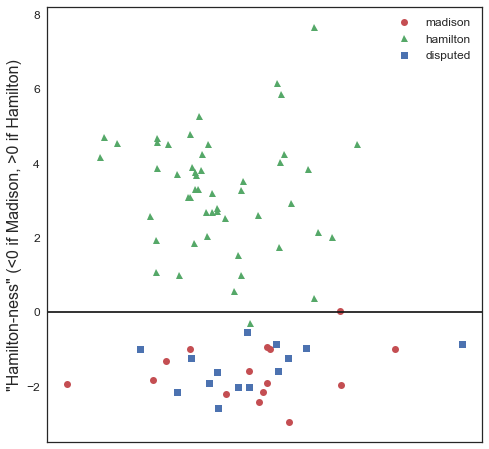

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(np.random.normal(0.0, 1.0, len(m)), m, 'o', color='r', label='madison')
ax.plot(np.random.normal(0.0, 1.0, len(h)), h, '^', color='g', label='hamilton')
ax.plot(np.random.normal(0.0, 1.0, len(u)), u, 's', color='b', label='disputed')

ax.axhline(y=0, color='k')

ax.set_xticks([])
ax.set_ylabel('"Hamilton-ness" (<0 if Madison, >0 if Hamilton)')
ax.legend(loc=1);

force_aspect(ax, 1)

You can see that, although all of the disputed papers happen to fall below this plane, the separation really isn't all that strong.  You can also see (as we found before) that one each of Madison's and Hamilton's papers from the training set are mis-attributed.

So unfortunately this method doesn't seem terribly reliable... certainly not enough to settle a 200+ year-old academic and political feud!

We can redo it with the larger sample of words, just to see if we do any better:

## Next, let's take a look at set2 (with $\Delta > 0.5$):

This data is noisier, but there is more of it, so maybe it will help us in our determinations.  For convenience, I'll roll our analysis into a function:

In [57]:
def analyze_svc(wordlist):
    # tally word occurrences in the the known and disputed federalist papers
    mad_data = [ measure(f, wordlist) for f in glob.glob('../authors/madison/*.txt') ]
    ham_data = [ measure(f, wordlist) for f in glob.glob('../authors/hamilton/*.txt') ]

    test_files = glob.glob('../authors/unknown-federalist/*.txt')
    u_data = [ measure(f, wordlist) for f in test_files ]
    
    # fit a linear classifier
    x = np.vstack((mad_data, ham_data))
    y = [0] * len(mad_data) + [1] * len(ham_data)

    scale = np.std(x, axis=0) + 1.0e-6
    x = x / scale

    clf = svm.SVC(kernel='linear')
    clf.fit(x, y)

    # print predictions for the disputed papers
    result = clf.predict(u_data/scale)
    result = [ 'hamilton' if r else 'madison' for r in result ]

    for name, author in zip(names, result):
        print "Federalist #", name, ":", author
        
    # plot the results visually
    b = clf.intercept_[0]
    v = clf.coef_[0] / scale
    
    m = [ np.dot(v, el) + b for el in mad_data ]
    h = [ np.dot(v, el) + b for el in ham_data ]
    u = [ np.dot(v, el) + b for el in   u_data ]
    
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(np.random.normal(0.0, 1.0, len(m)), m, 'o', color='r', label='madison')
    ax.plot(np.random.normal(0.0, 1.0, len(h)), h, '^', color='g', label='hamilton')
    ax.plot(np.random.normal(0.0, 1.0, len(u)), u, 's', color='b', label='disputed')

    ax.axhline(y=0, color='k')

    ax.set_xticks([])
    ax.set_ylabel('"Hamilton-ness" (<0 if Madison, >0 if Hamilton)')
    ax.legend(loc='best');

    force_aspect(ax, 1)
    
    return (b, v)

Federalist # 18 : madison
Federalist # 19 : madison
Federalist # 20 : madison
Federalist # 49 : madison
Federalist # 50 : madison
Federalist # 51 : madison
Federalist # 52 : madison
Federalist # 53 : madison
Federalist # 54 : madison
Federalist # 55 : hamilton
Federalist # 56 : madison
Federalist # 57 : madison
Federalist # 62 : madison
Federalist # 63 : madison


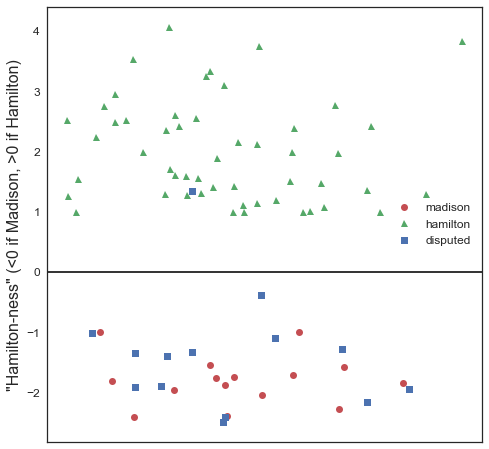

In [58]:
b, v = analyze_svc(set2)

Oh, no -- one of our determinations has changed!  Now it looks like Hamilton may have written Federalist #55.

Again, we can plot distances from the hyperplane to gauge how well the model performs:

Now we've separated our training data much more effectively, which looks promising.  But note that Federalist #55 has moved significantly, and is now *firmly* in Hamilton's territory.  It's not comforting to see such a marked change in our predictions.

Moreover, I just don't think this model is very well-motivated for our present calculation.  Even if Hamilton tends to us "on" while Madison prefers "upon," and Hamilton uses "there" more than Madison, who says that in the few instances where Madison uses "on" more often, he also uses "there" less often?  I see no reason why such a correlation should exist.

The computer will always be able to find such correlations, if you give it enough words to check, but I think it's essentially just picking up on noise in the training data.

To demonstrate the fungibility of our model, I can add Federalist #55 (which is very clearly on the Hamilton side) to the training data.  If I tell the model that Madison wrote it, the SVM will happily find a new separating hyperplane, and now reports that Madison wrote everything:

In [62]:
ind = names.index('55')

# tally word occurrences in the the known and disputed federalist papers
mad_data = [ measure(f, set2) for f in glob.glob('../authors/madison/*.txt') ]
ham_data = [ measure(f, set2) for f in glob.glob('../authors/hamilton/*.txt') ]

test_files = glob.glob('../authors/unknown-federalist/*.txt')
u_data = [ measure(f, set2) for f in test_files ]

# fit a linear classifier, adding federalist #55 to the training data:
x = np.vstack((mad_data, ham_data, [u_data[ind]]))
y = [0] * len(mad_data) + [1] * len(ham_data) + [0]

scale = np.std(x, axis=0) + 1.0e-6
x = x / scale

clf = svm.SVC(kernel='linear')
clf.fit(x, y)

# print predictions for the disputed papers
result = clf.predict(u_data/scale)
result = [ 'hamilton' if r else 'madison' for r in result ]

for name, author in zip(names, result):
    print "Federalist #", name, ":", author

Federalist # 18 : madison
Federalist # 19 : madison
Federalist # 20 : madison
Federalist # 49 : madison
Federalist # 50 : madison
Federalist # 51 : madison
Federalist # 52 : madison
Federalist # 53 : madison
Federalist # 54 : madison
Federalist # 55 : madison
Federalist # 56 : madison
Federalist # 57 : madison
Federalist # 62 : madison
Federalist # 63 : madison


So our model is sensitive to noise, has possibly been trained on noise, and is subject to huge swings in its predictions based on small changes in the training set.

Nonetheless, this model is the best we have so far, and it does seem suggestive that Madison wrote many, most, or perhaps all of the disputed papers.  This model is in fact better than at least a few which have been published in peer-reviewed journals, so let's save it for posterity:

In [60]:
fact = 10 * v / np.linalg.norm(v)

terms = sorted(zip(fact, set2), 
               key = lambda(a, b) : abs(a), 
               reverse=True)

def format_term(term):
    weight, word = term
    
    s = '-' if np.sign(weight) < 0 else '+'
    weight = '{0:.1f}'.format(abs(weight))
    return s + ' (' + weight + ' ' + word + ')'
    

'H = ' '{0:.1f}'.format(10*b) + ' ' + \
' '.join(map(format_term, terms))

'H = -14.3 + (6.4 kind) + (4.7 upon) + (4.2 there) + (3.9 at) - (1.5 on) - (1.0 by) + (0.8 would) + (0.6 to) - (0.5 and)'

We might call this the "Hamilton index:" we predict Hamilton wrote the paper if $H>0$, otherwise Madison.

## What happens if we use *even more* data?

I can try re-running the model with the *full* list of stopwords, hoping that I can surmount the problems with this method by overwhelming it with data:

Federalist # 18 : madison
Federalist # 19 : madison
Federalist # 20 : hamilton
Federalist # 49 : madison
Federalist # 50 : madison
Federalist # 51 : madison
Federalist # 52 : madison
Federalist # 53 : madison
Federalist # 54 : madison
Federalist # 55 : madison
Federalist # 56 : madison
Federalist # 57 : madison
Federalist # 62 : madison
Federalist # 63 : madison


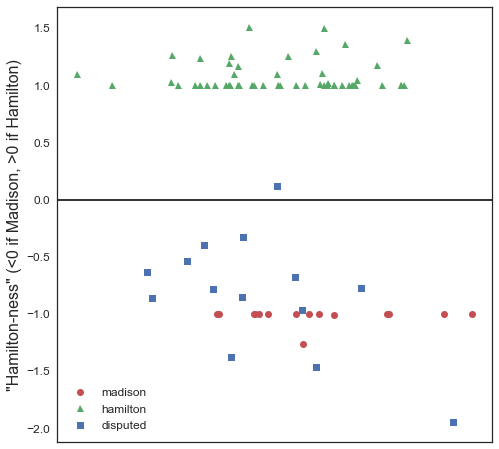

In [56]:
analyze_svc(stopwords)

again, the predictions have changed, which is not encouraging.  Moreover, while the model now does an excellent job at separating the training data, it performs much less well on the disputed papers.  This is a clear sign of regression or selection effects; i.e., that we've trained the model on noise in the training data and that it isn't terribly predictive.